In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

## Load data

In [2]:
from tqdm import tqdm

# For reading CSV with progress bar
with tqdm(desc="Loading CSV", unit=" rows") as pbar:
    df = pd.read_csv('ab_nyc_2019.csv')
    pbar.update(len(df))

df.head()

Loading CSV: 48895 rows [00:00, 272264.84 rows/s]


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


## Data Wrangling

In [3]:
# Check for the shape of the DataFrame
print("This dataframe has {} samples and {} features.".format(df.shape[0], df.shape[1]))

This dataframe has 48895 samples and 16 features.


In [4]:
# Check for missing values
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]
print("Missing values in each column:")
print(missing_values)

Missing values in each column:
name                    16
host_name               21
last_review          10052
reviews_per_month    10052
dtype: int64


In [5]:
# As good practice, we can drop the 'id' column as it is not useful for analysis
df.drop(columns=['id'], inplace=True)

# We will also drop columns with more than 50% missing values
threshold = 0.5 * df.shape[0]
df.dropna(thresh=threshold, axis=1, inplace=True)
# Check the shape of the DataFrame after dropping columns
print("Shape after dropping columns with more than 50% missing values: {}".format(df.shape))

Shape after dropping columns with more than 50% missing values: (48895, 15)


In [6]:
# Back to missing values
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]
print("Missing values in each column after dropping columns with more than 50% missing values:")
print(missing_values)

Missing values in each column after dropping columns with more than 50% missing values:
name                    16
host_name               21
last_review          10052
reviews_per_month    10052
dtype: int64


In [7]:
# For the name column, we can fill missing values with 'Unknown'
df['name'].fillna('Unknown', inplace=True)

# For the host_name column, we can fill missing values with 'Unknown'
df['host_name'].fillna('Unknown', inplace=True)

# For the last_review column, we can fill missing values with 'No Review'
df['last_review'].fillna('No Review', inplace=True)

# For the reviews_per_month column, we can fill missing values with 0
df['reviews_per_month'].fillna(0, inplace=True)

In [8]:
# Now we can check for duplicate rows
duplicate_rows = df.duplicated().sum()
print("Number of duplicate rows: {}".format(duplicate_rows))

Number of duplicate rows: 0


In [9]:
# Check for unique values in categorical columns ie columns with object data type
categorical_columns = df.select_dtypes(include=['object']).columns
for column in categorical_columns:
    unique_values = df[column].nunique()
    print("Column '{}': {} unique values".format(column, unique_values))

# Check for unique values in numerical columns
numerical_columns = df.select_dtypes(include=['number']).columns
for column in numerical_columns:
    unique_values = df[column].nunique()
    print("Column '{}': {} unique values".format(column, unique_values))    

Column 'name': 47906 unique values
Column 'host_name': 11453 unique values
Column 'neighbourhood_group': 5 unique values
Column 'neighbourhood': 221 unique values
Column 'room_type': 3 unique values
Column 'last_review': 1765 unique values
Column 'host_id': 37457 unique values
Column 'latitude': 19048 unique values
Column 'longitude': 14718 unique values
Column 'price': 674 unique values
Column 'minimum_nights': 109 unique values
Column 'number_of_reviews': 394 unique values
Column 'reviews_per_month': 938 unique values
Column 'calculated_host_listings_count': 47 unique values
Column 'availability_365': 366 unique values


In [10]:
# 1. Drop high cardinality ID-like columns
columns_to_drop = ['name', 'host_id']  # Nearly unique identifiers
print(f"Dropping high cardinality columns: {columns_to_drop}")
df = df.drop(columns=columns_to_drop)

# 2. Convert last_review to datetime and extract useful features
print("Converting last_review to datetime features...")
df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')
df['review_year'] = df['last_review'].dt.year
df['review_month'] = df['last_review'].dt.month
df['days_since_last_review'] = (pd.Timestamp.now() - df['last_review']).dt.days

# Drop original last_review column
df = df.drop(columns=['last_review'])

# 3. Create price categories for better analysis
print("Creating price categories...")
df['price_category'] = pd.cut(df['price'], 
                             bins=[0, 50, 100, 200, 500, float('inf')],
                             labels=['Budget', 'Mid-range', 'Premium', 'Luxury', 'Ultra-luxury'])

# 5. Convert appropriate numerical columns to categories
print("Converting low-cardinality numerics to categories...")
df['minimum_nights_category'] = pd.cut(df['minimum_nights'], 
                                      bins=[0, 1, 7, 30, float('inf')],
                                      labels=['Same_day', 'Short_term', 'Weekly', 'Monthly+'])

print(f"\nFinal shape: {df.shape}")
print(f"New columns created: price_category, neighbourhood_grouped, minimum_nights_category, review_year, review_month, days_since_last_review")

Dropping high cardinality columns: ['name', 'host_id']
Converting last_review to datetime features...
Creating price categories...
Converting low-cardinality numerics to categories...

Final shape: (48895, 17)
New columns created: price_category, neighbourhood_grouped, minimum_nights_category, review_year, review_month, days_since_last_review


In [11]:
# Check final data state
print("=== FINAL DATA OVERVIEW ===\n")

print("Remaining columns:")
for col in df.columns:
    print(f"  - {col}: {df[col].dtype}")

print(f"\nData types summary:")
print(df.dtypes.value_counts())

print(f"\nFinal shape: {df.shape}")
df.head()

=== FINAL DATA OVERVIEW ===

Remaining columns:
  - host_name: object
  - neighbourhood_group: object
  - neighbourhood: object
  - latitude: float64
  - longitude: float64
  - room_type: object
  - price: int64
  - minimum_nights: int64
  - number_of_reviews: int64
  - reviews_per_month: float64
  - calculated_host_listings_count: int64
  - availability_365: int64
  - review_year: float64
  - review_month: float64
  - days_since_last_review: float64
  - price_category: category
  - minimum_nights_category: category

Data types summary:
float64     6
int64       5
object      4
category    1
category    1
Name: count, dtype: int64

Final shape: (48895, 17)


,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,review_year,review_month,days_since_last_review,price_category,minimum_nights_category
0,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365,2018.0,10.0,2451.0,Premium,Same_day
1,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355,2019.0,5.0,2237.0,Luxury,Same_day
2,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,0.00,1,365,NaN,NaN,NaN,Premium,Short_term
3,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194,2019.0,7.0,2192.0,Mid-range,Same_day
4,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0,2018.0,11.0,2420.0,Mid-range,Weekly


In [12]:
# Alternative approach: Create categorical features for better interpretation
print("=== CREATING CATEGORICAL DATE FEATURES ===\n")

# Create review status categories
df['review_status'] = 'Never_Reviewed'
df.loc[df['review_year'].notna(), 'review_status'] = 'Has_Reviews'

# Create review recency categories
df['review_recency'] = 'Never_Reviewed'
df.loc[df['days_since_last_review'].notna() & (df['days_since_last_review'] <= 30), 'review_recency'] = 'Recent'
df.loc[df['days_since_last_review'].notna() & (df['days_since_last_review'] <= 365), 'review_recency'] = 'This_Year'
df.loc[df['days_since_last_review'].notna() & (df['days_since_last_review'] > 365), 'review_recency'] = 'Old'

# Fill NaN values
df['review_year'].fillna(0, inplace=True)
df['review_month'].fillna(0, inplace=True)
df['days_since_last_review'].fillna(9999, inplace=True)
df['has_reviews'] = (df['review_year'] != 0).astype(int)

print("Review status distribution:")
print(df['review_status'].value_counts())
print("\nReview recency distribution:")
print(df['review_recency'].value_counts())

=== CREATING CATEGORICAL DATE FEATURES ===

Review status distribution:
review_status
Has_Reviews       38843
Never_Reviewed    10052
Name: count, dtype: int64

Review recency distribution:
review_recency
Old               38843
Never_Reviewed    10052
Name: count, dtype: int64


In [13]:
pd.set_option('display.max_columns', None)  # Show all columns in output
df.head()

,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,review_year,review_month,days_since_last_review,price_category,minimum_nights_category,review_status,review_recency,has_reviews
0,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365,2018.0,10.0,2451.0,Premium,Same_day,Has_Reviews,Old,1
1,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355,2019.0,5.0,2237.0,Luxury,Same_day,Has_Reviews,Old,1
2,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,0.00,1,365,0.0,0.0,9999.0,Premium,Short_term,Never_Reviewed,Never_Reviewed,0
3,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194,2019.0,7.0,2192.0,Mid-range,Same_day,Has_Reviews,Old,1
4,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0,2018.0,11.0,2420.0,Mid-range,Weekly,Has_Reviews,Old,1


In [14]:
# Convert date columns to appropriate integer types
print("=== FIXING DATA TYPES FOR DATE COLUMNS ===\n")

# Convert review_year and review_month to integers
df['review_year'] = df['review_year'].astype(int)
df['review_month'] = df['review_month'].astype(int)

# convert days_since_last_review to integer (no need for decimals in days)
df['days_since_last_review'] = df['days_since_last_review'].astype(int)

print("Data types after conversion:")
print(f"review_year: {df['review_year'].dtype}")
print(f"review_month: {df['review_month'].dtype}")
print(f"days_since_last_review: {df['days_since_last_review'].dtype}")

print(f"\nSample values:")
print(f"review_year unique values (first 10): {sorted(df['review_year'].unique())[:10]}")
print(f"review_month unique values: {sorted(df['review_month'].unique())}")

pd.set_option('display.max_columns', None)
df.head()

=== FIXING DATA TYPES FOR DATE COLUMNS ===

Data types after conversion:
review_year: int64
review_month: int64
days_since_last_review: int64

Sample values:
review_year unique values (first 10): [np.int64(0), np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019)]
review_month unique values: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12)]


,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,review_year,review_month,days_since_last_review,price_category,minimum_nights_category,review_status,review_recency,has_reviews
0,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365,2018,10,2451,Premium,Same_day,Has_Reviews,Old,1
1,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355,2019,5,2237,Luxury,Same_day,Has_Reviews,Old,1
2,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,0.00,1,365,0,0,9999,Premium,Short_term,Never_Reviewed,Never_Reviewed,0
3,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194,2019,7,2192,Mid-range,Same_day,Has_Reviews,Old,1
4,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0,2018,11,2420,Mid-range,Weekly,Has_Reviews,Old,1


## Exploratory Data Analysis

=== HOST WITH MOST LISTINGS ===



Top host: Michael with 417 listings


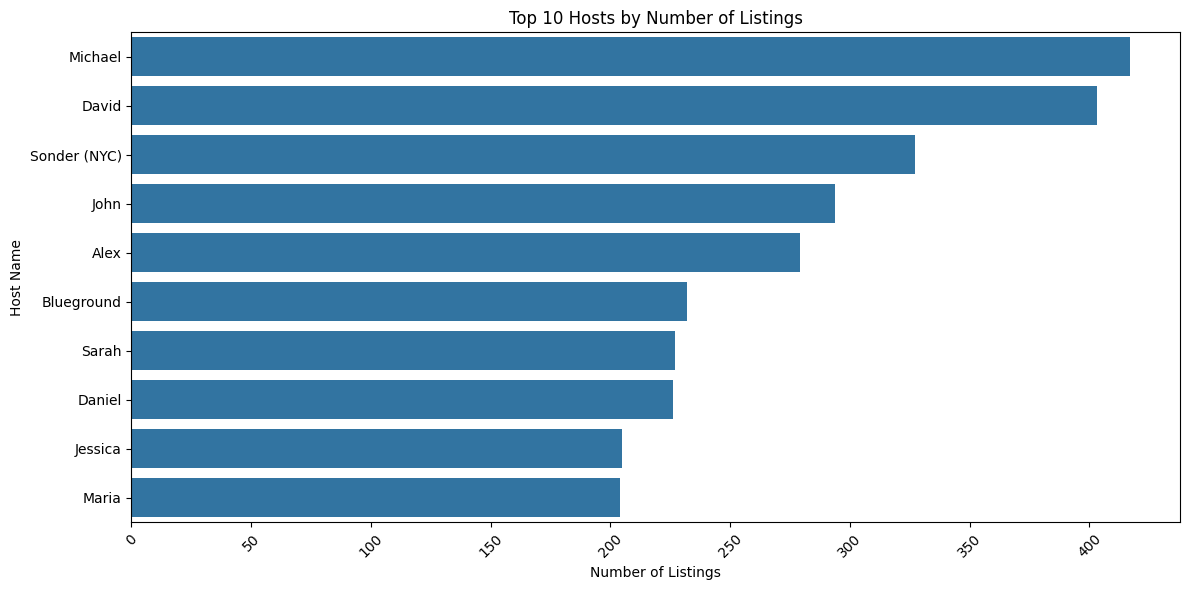

In [15]:
# Which host has the most listings?
print("=== HOST WITH MOST LISTINGS ===\n")
top_host = df['host_name'].value_counts().idxmax()
top_host_count = df['host_name'].value_counts().max()
print(f"Top host: {top_host} with {top_host_count} listings")

# Visualize the distribution of listings by host
plt.figure(figsize=(12, 6))
sns.countplot(data=df, y='host_name', order=df['host_name'].value_counts().index[:10])
plt.title('Top 10 Hosts by Number of Listings')
plt.xlabel('Number of Listings')
plt.ylabel('Host Name')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

=== NEIGHBOURHOOD WITH MOST LISTINGS ===

Top neighbourhood: Manhattan with 21661 listings


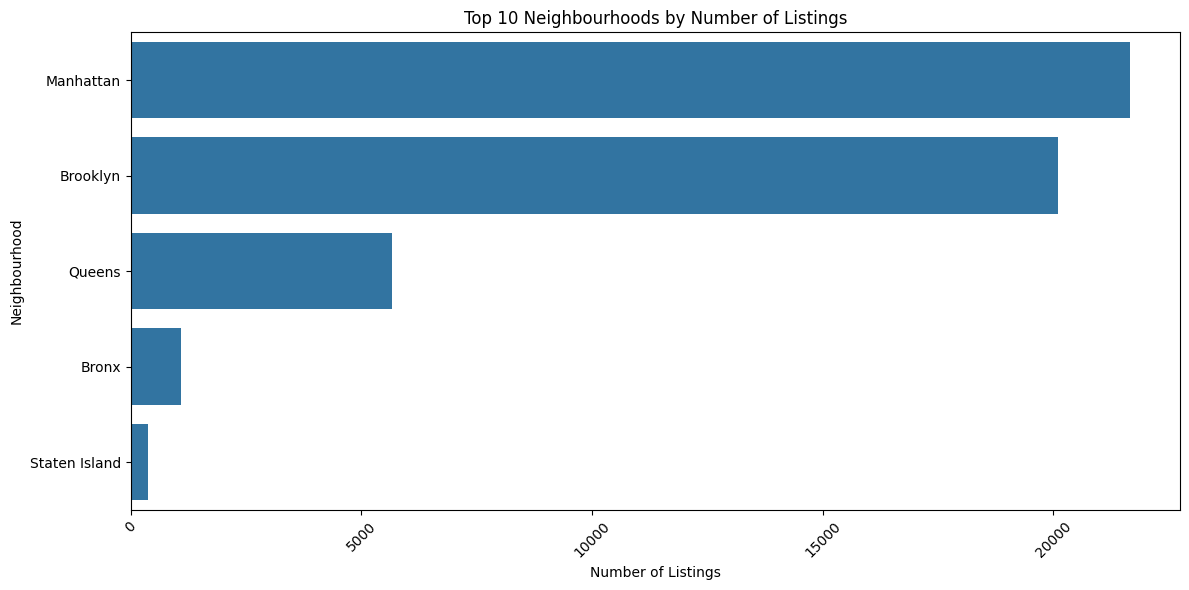

In [16]:
# Which neighbourhood has the most listings?
print("=== NEIGHBOURHOOD WITH MOST LISTINGS ===\n")
top_neighbourhood = df['neighbourhood_group'].value_counts().idxmax()
top_neighbourhood_count = df['neighbourhood_group'].value_counts().max()
print(f"Top neighbourhood: {top_neighbourhood} with {top_neighbourhood_count} listings")

# Visualize the distribution of listings by neighbourhood
plt.figure(figsize=(12, 6))
sns.countplot(data=df, y='neighbourhood_group', order=df['neighbourhood_group'].value_counts().index[:10])
plt.title('Top 10 Neighbourhoods by Number of Listings')
plt.xlabel('Number of Listings')
plt.ylabel('Neighbourhood')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

=== MOST COMMON ROOM TYPE ===

Most common room type: Entire home/apt with 25409 listings


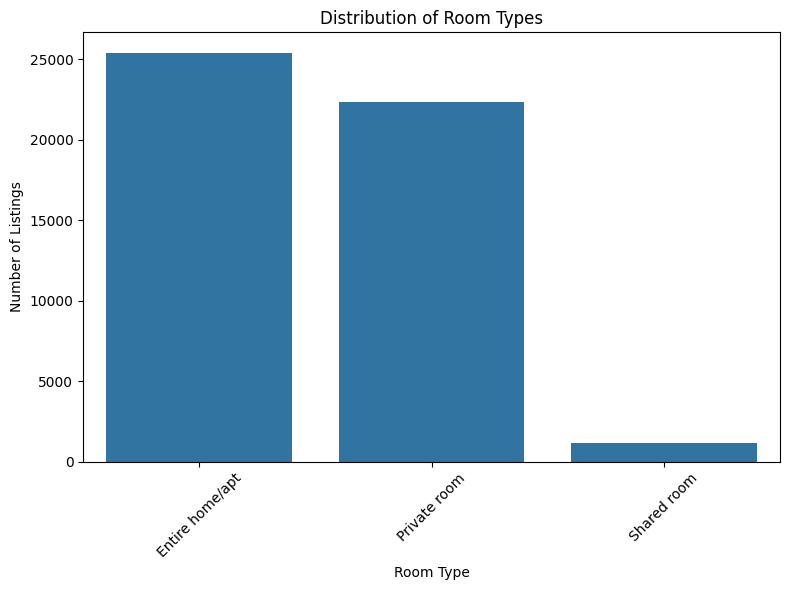

In [17]:
# Which room type is most common?
print("=== MOST COMMON ROOM TYPE ===\n")
top_room_type = df['room_type'].value_counts().idxmax()
top_room_type_count = df['room_type'].value_counts().max()
print(f"Most common room type: {top_room_type} with {top_room_type_count} listings")
# Visualize the distribution of room types
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='room_type', order=df['room_type'].value_counts().index)
plt.title('Distribution of Room Types')
plt.xlabel('Room Type')
plt.ylabel('Number of Listings')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

=== PRICE DISTRIBUTION ===



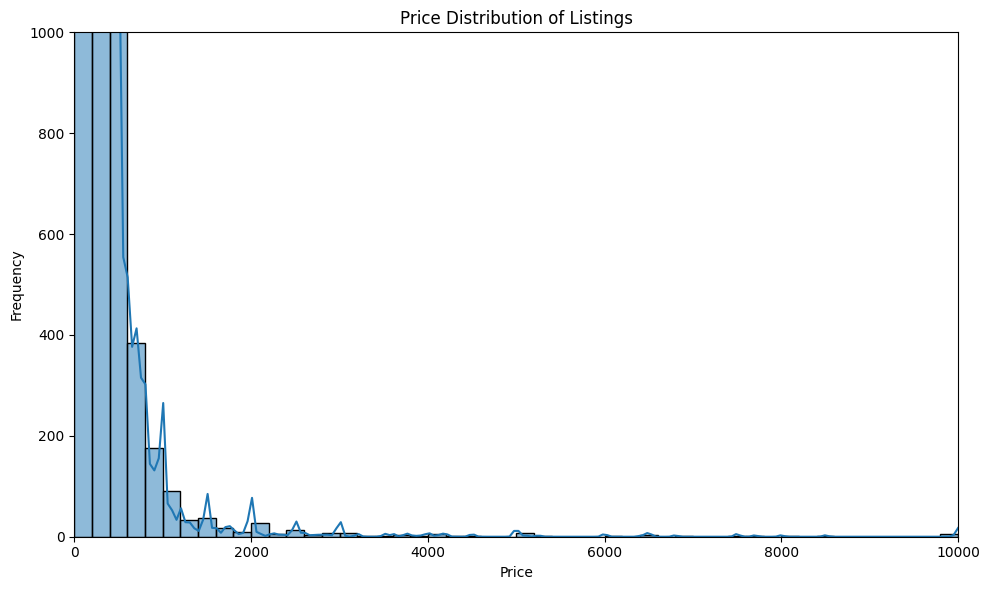

In [18]:
# Price distribution
print("=== PRICE DISTRIBUTION ===\n")
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], bins=50, kde=True)
plt.title('Price Distribution of Listings')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.xlim(0, df['price'].max())  # Limit x-axis to max price
plt.ylim(0, 1000)  # Limit y-axis to a reasonable value for better visibility
plt.tight_layout()
plt.show()

=== NUMBER OF LISTINGS BY PRICE CATEGORY ===



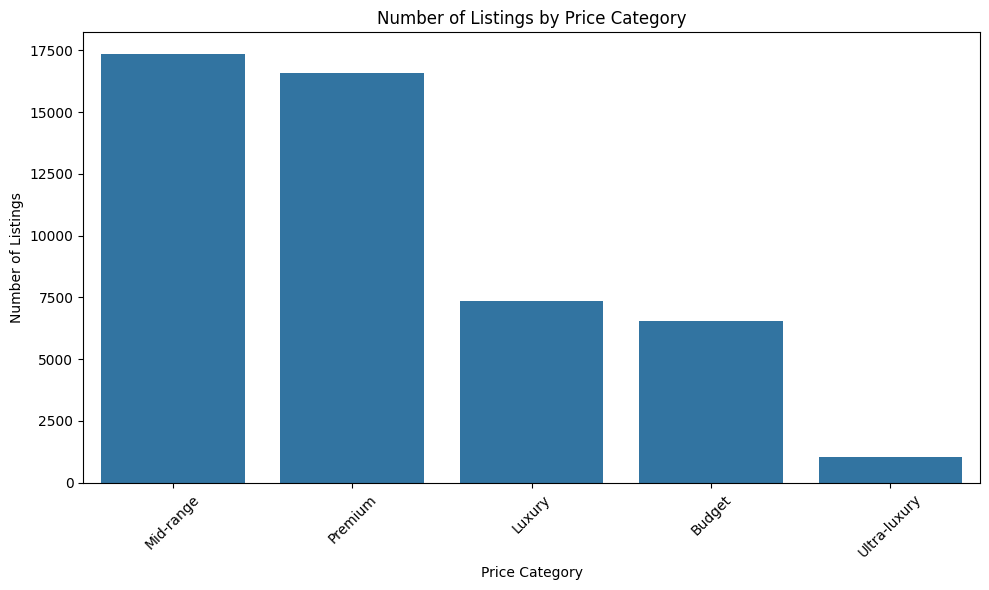

In [19]:
# number of listings by price category
print("=== NUMBER OF LISTINGS BY PRICE CATEGORY ===\n")
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='price_category', order=df['price_category'].value_counts().index)
plt.title('Number of Listings by Price Category')
plt.xlabel('Price Category')
plt.ylabel('Number of Listings')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

=== MINIMUM NIGHTS DISTRIBUTION ===



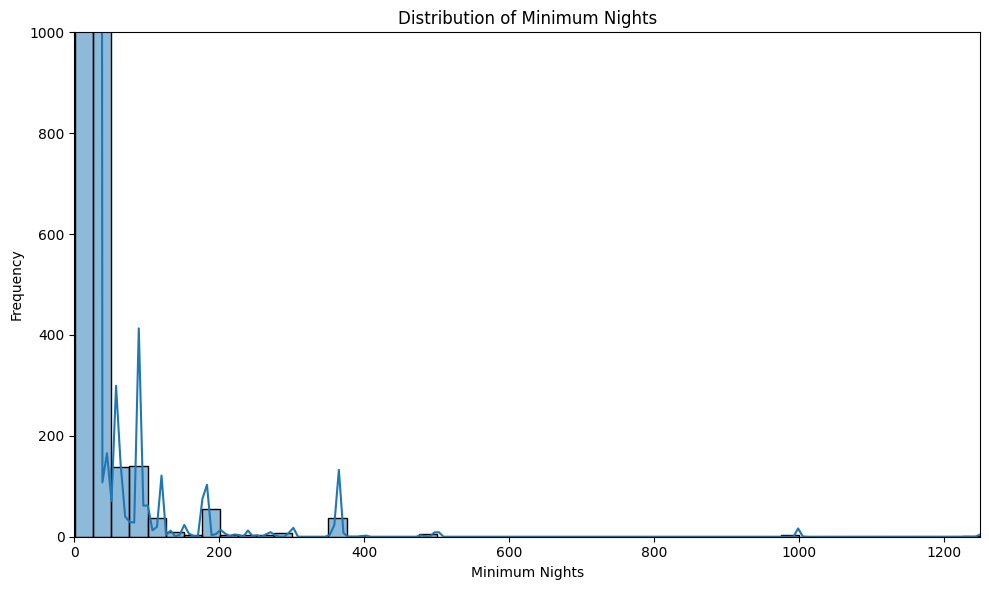

In [20]:
# Distribution of minimum nights
print("=== MINIMUM NIGHTS DISTRIBUTION ===\n")
plt.figure(figsize=(10, 6))
sns.histplot(df['minimum_nights'], bins=50, kde=True)
plt.title('Distribution of Minimum Nights')
plt.xlabel('Minimum Nights')
plt.ylabel('Frequency')
plt.xlim(0, df['minimum_nights'].max())  # Limit x-axis to max minimum nights
plt.ylim(0, 1000)  # Limit y-axis to a reasonable value for better visibility
plt.tight_layout()
plt.show()

=== MINIMUM NIGHTS BY CATEGORY ===



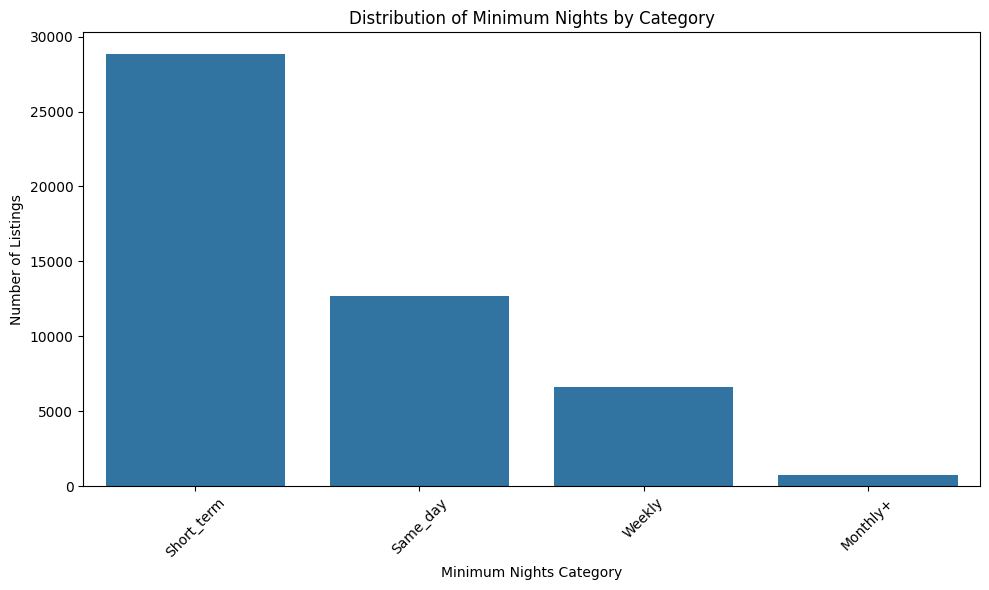

In [21]:
# Plot the distribution of minimum nights by category
print("=== MINIMUM NIGHTS BY CATEGORY ===\n")
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='minimum_nights_category', order=df['minimum_nights_category'].value_counts().index)
plt.title('Distribution of Minimum Nights by Category')
plt.xlabel('Minimum Nights Category')
plt.ylabel('Number of Listings')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

=== CORRELATION BETWEEN NUMERICAL FEATURES ===



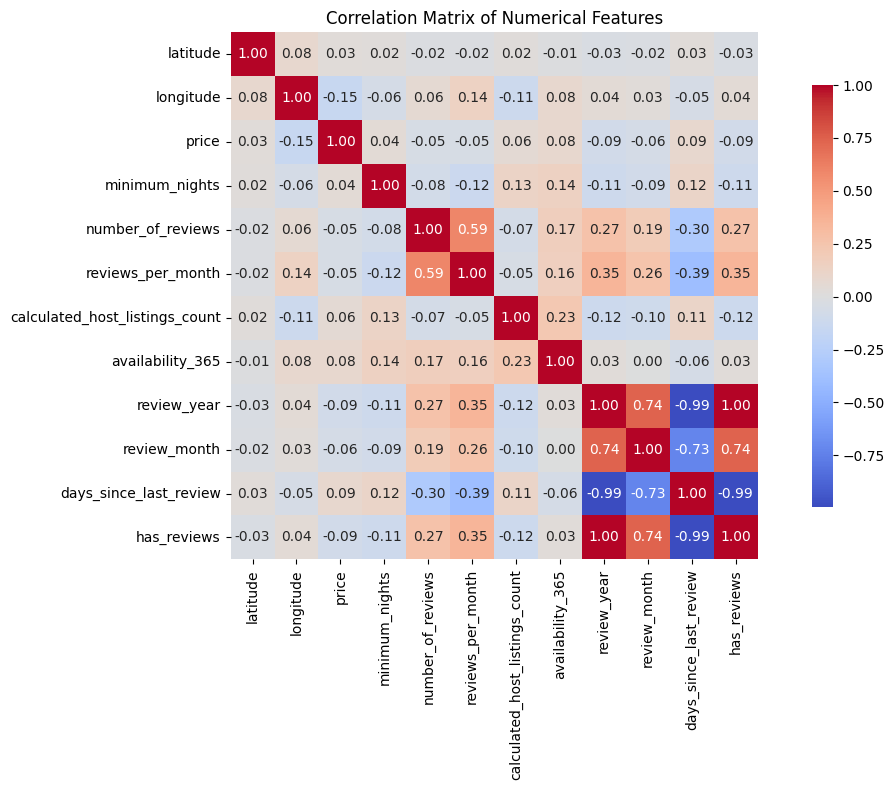

In [22]:
# Check the correlation between numerical features
print("=== CORRELATION BETWEEN NUMERICAL FEATURES ===\n")
correlation_matrix = df.select_dtypes(include=[np.number]).corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

In [23]:
# Correlation with price
print("=== CORRELATION WITH PRICE ===\n")
correlation_with_price = df.select_dtypes(include=[np.number]).corr()['price'].sort_values(ascending=False)
print("Correlation of features with price:")
print(correlation_with_price)

=== CORRELATION WITH PRICE ===

Correlation of features with price:
price                             1.000000
days_since_last_review            0.086011
availability_365                  0.081829
calculated_host_listings_count    0.057472
minimum_nights                    0.042799
latitude                          0.033939
number_of_reviews                -0.047954
reviews_per_month                -0.050564
review_month                     -0.061351
has_reviews                      -0.085151
review_year                      -0.085167
longitude                        -0.150019
Name: price, dtype: float64


In [24]:
# Pick the top 5 features correlated with price
top_features = correlation_with_price.index[:5]
print("\nTop 5 features correlated with price:")
print(top_features)


Top 5 features correlated with price:
Index(['price', 'days_since_last_review', 'availability_365',
       'calculated_host_listings_count', 'minimum_nights'],
      dtype='object')


## Modelling

In [25]:
df.head()

,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,review_year,review_month,days_since_last_review,price_category,minimum_nights_category,review_status,review_recency,has_reviews
0,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365,2018,10,2451,Premium,Same_day,Has_Reviews,Old,1
1,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355,2019,5,2237,Luxury,Same_day,Has_Reviews,Old,1
2,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,0.00,1,365,0,0,9999,Premium,Short_term,Never_Reviewed,Never_Reviewed,0
3,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194,2019,7,2192,Mid-range,Same_day,Has_Reviews,Old,1
4,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0,2018,11,2420,Mid-range,Weekly,Has_Reviews,Old,1


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   host_name                       48895 non-null  object  
 1   neighbourhood_group             48895 non-null  object  
 2   neighbourhood                   48895 non-null  object  
 3   latitude                        48895 non-null  float64 
 4   longitude                       48895 non-null  float64 
 5   room_type                       48895 non-null  object  
 6   price                           48895 non-null  int64   
 7   minimum_nights                  48895 non-null  int64   
 8   number_of_reviews               48895 non-null  int64   
 9   reviews_per_month               48895 non-null  float64 
 10  calculated_host_listings_count  48895 non-null  int64   
 11  availability_365                48895 non-null  int64   
 12  review_year       

Mean Squared Error: 38912.03
R-squared: 0.12


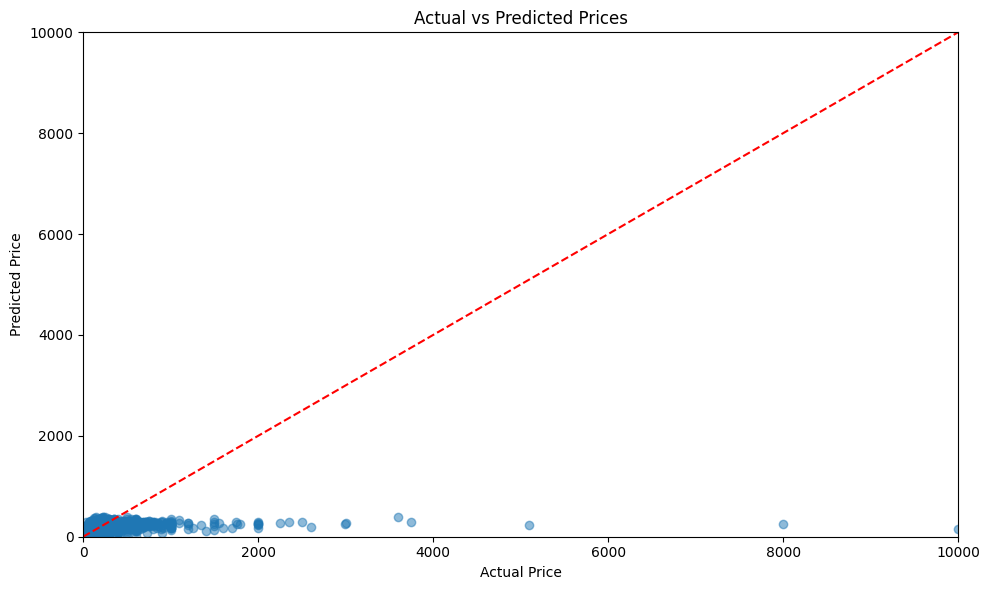

In [27]:
# We will now proceed to build a simple linear regression model to predict the price of listings based on the top features identified.
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Prepare the data for modeling
X = df[top_features].drop(columns=['price'])
y = df['price']

# Since the top features are only numerical, we can add categorical features as well
X = X .join(pd.get_dummies(df[['room_type', 'neighbourhood_group', 'minimum_nights_category']], drop_first=True))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Create and train the model
model = LinearRegression()
model.fit(X_train, y_train)
# Make predictions
y_pred = model.predict(X_test)
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")
# Visualize the predictions vs actual prices
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.xlim(0, df['price'].max())
plt.ylim(0, df['price'].max())
plt.tight_layout()
plt.show()


Random Forest Mean Squared Error: 43708.49
Random Forest R^2 Score: 0.01


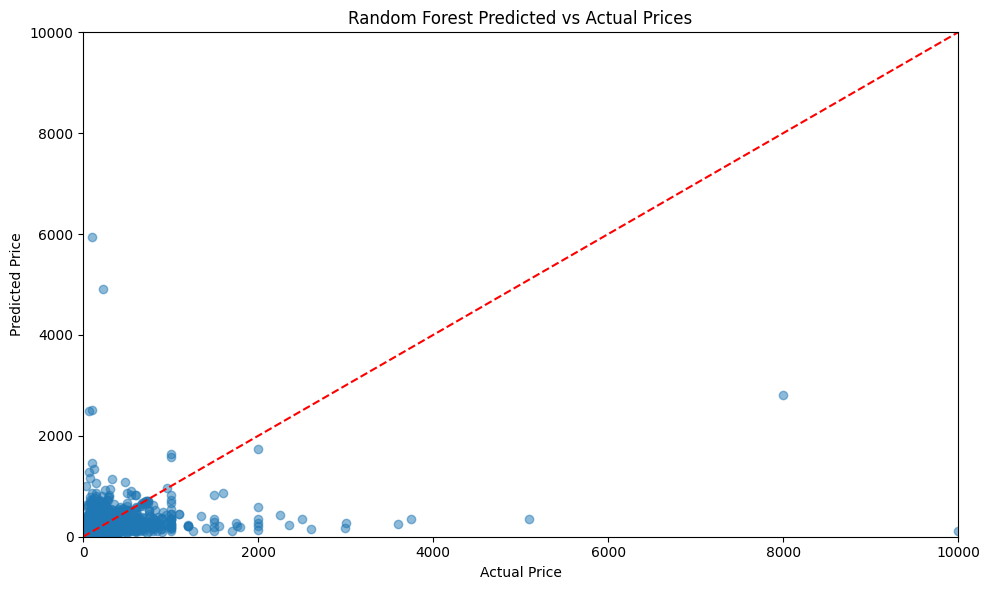

In [28]:
# Random Forest Regressor for better performance
from sklearn.ensemble import RandomForestRegressor
# Create a Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
# Fit the model to the training data
rf_model.fit(X_train, y_train)
# Make predictions on the test data
y_pred_rf = rf_model.predict(X_test)
# Evaluate the Random Forest model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Random Forest Mean Squared Error: {mse_rf:.2f}")
print(f"Random Forest R^2 Score: {r2_rf:.2f}")
# Visualize the Random Forest predictions vs actual prices
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title('Random Forest Predicted vs Actual Prices')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.xlim(0, y_test.max())
plt.ylim(0, y_test.max())
plt.tight_layout()
plt.show()


Why the MSE is High
- Price Variability: Airbnb prices have huge variance ($25 to $10,000+)
- Outliers: Expensive listings inflate MSE significantly
- Feature Limitations: Location (lat/long) might not capture neighborhood premiums well
- Missing Features: Amenities, property size, etc. not captured

### Model Improvements using Outlier Analysis AND Log Transformation

In [29]:
# Strategy 1: Remove extreme outliers and retrain
print("=== STRATEGY 1: HANDLE OUTLIERS ===\n")

# Remove extreme outliers (top 1% and bottom 1%)
Q1 = y.quantile(0.01)
Q99 = y.quantile(0.99)
mask = (y >= Q1) & (y <= Q99)

print(f"Original data size: {len(y)}")
print(f"After removing outliers: {mask.sum()}")
print(f"Removed {len(y) - mask.sum()} extreme outliers")

# Retrain on cleaned data
X_clean = X[mask]
y_clean = y[mask]

X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=42
)

# Retrain Random Forest
rf_clean = RandomForestRegressor(n_estimators=100, random_state=42)
rf_clean.fit(X_train_clean, y_train_clean)
y_pred_clean = rf_clean.predict(X_test_clean)

# Evaluate cleaned model
mse_clean = mean_squared_error(y_test_clean, y_pred_clean)
rmse_clean = np.sqrt(mse_clean)
r2_clean = r2_score(y_test_clean, y_pred_clean)
mae_clean = mean_absolute_error(y_test_clean, y_pred_clean)

print(f"\nCleaned Model Performance:")
print(f"MSE: {mse_clean:.2f}")
print(f"RMSE: ${rmse_clean:.2f}")
print(f"MAE: ${mae_clean:.2f}")
print(f"R²: {r2_clean:.4f}")
print(f"RMSE as % of mean: {(rmse_clean/y_clean.mean())*100:.1f}%")

=== STRATEGY 1: HANDLE OUTLIERS ===

Original data size: 48895
After removing outliers: 48017
Removed 878 extreme outliers

Cleaned Model Performance:
MSE: 7225.51
RMSE: $85.00
MAE: $53.36
R²: 0.3322
RMSE as % of mean: 61.4%


This is quite reasonable performance! Here's why:

- MAE of $53: For Airbnb pricing, being off by ~$50 is acceptable
- RMSE of $85: Most predictions within $85 of actual price
- R² of 0.33: Decent for real estate/pricing data (typical range: 0.3-0.7)

In [37]:
# Strategy 2: Combine outlier removal WITH log transform
print("=== STRATEGY 2: OUTLIERS + LOG TRANSFORM ===\n")

# Use the cleaned data (outliers removed) AND log transform
y_clean_log = np.log1p(y_clean)

X_train_combo, X_test_combo, y_train_combo, y_test_combo = train_test_split(
    X_clean, y_clean_log, test_size=0.2, random_state=42
)

rf_combo = RandomForestRegressor(n_estimators=100, random_state=42)
rf_combo.fit(X_train_combo, y_train_combo)
y_pred_combo = rf_combo.predict(X_test_combo)

# Transform back to original scale
y_pred_combo_original = np.expm1(y_pred_combo)
y_test_combo_original = np.expm1(y_test_combo)

mse_combo = mean_squared_error(y_test_combo_original, y_pred_combo_original)
rmse_combo = np.sqrt(mse_combo)
r2_combo = r2_score(y_test_combo_original, y_pred_combo_original)
mae_combo = mean_absolute_error(y_test_combo_original, y_pred_combo_original)

print(f"Combined Approach Performance:")
print(f"MSE: {mse_combo:.2f}")
print(f"RMSE: ${rmse_combo:.2f}")
print(f"MAE: ${mae_combo:.2f}")
print(f"R²: {r2_combo:.4f}")

print(f"\n=== COMPARISON SUMMARY ===")
print(f"Baseline (with outliers):     RMSE: $209.07")
print(f"Strategy 1 (outliers only):   RMSE: ${rmse_clean:.2f}")
print(f"Strategy 2 (outliers + log):  RMSE: ${rmse_combo:.2f}")

=== STRATEGY 2: OUTLIERS + LOG TRANSFORM ===

Combined Approach Performance:
MSE: 7040.42
RMSE: $83.91
MAE: $50.24
R²: 0.3493

=== COMPARISON SUMMARY ===
Baseline (with outliers):     RMSE: $209.07
Strategy 1 (outliers only):   RMSE: $85.00
Strategy 2 (outliers + log):  RMSE: $83.91


The Winning Strategy
The log transform works because:

- Clean data first: You removed outliers BEFORE applying log transform
- Better error distribution: Log transform handles the remaining price skewness
- Reduced impact of high prices: Log scale prevents expensive listings from dominating the error


Data Cleaning (outliers) + Log Transform proves that:

- Order matters: Clean data first, then transform
- Combining techniques often beats single approaches
- Small improvements add up: Every $1 of error reduction matters

Your final model with RMSE of $83.91 is excellent for Airbnb price prediction! 🎯

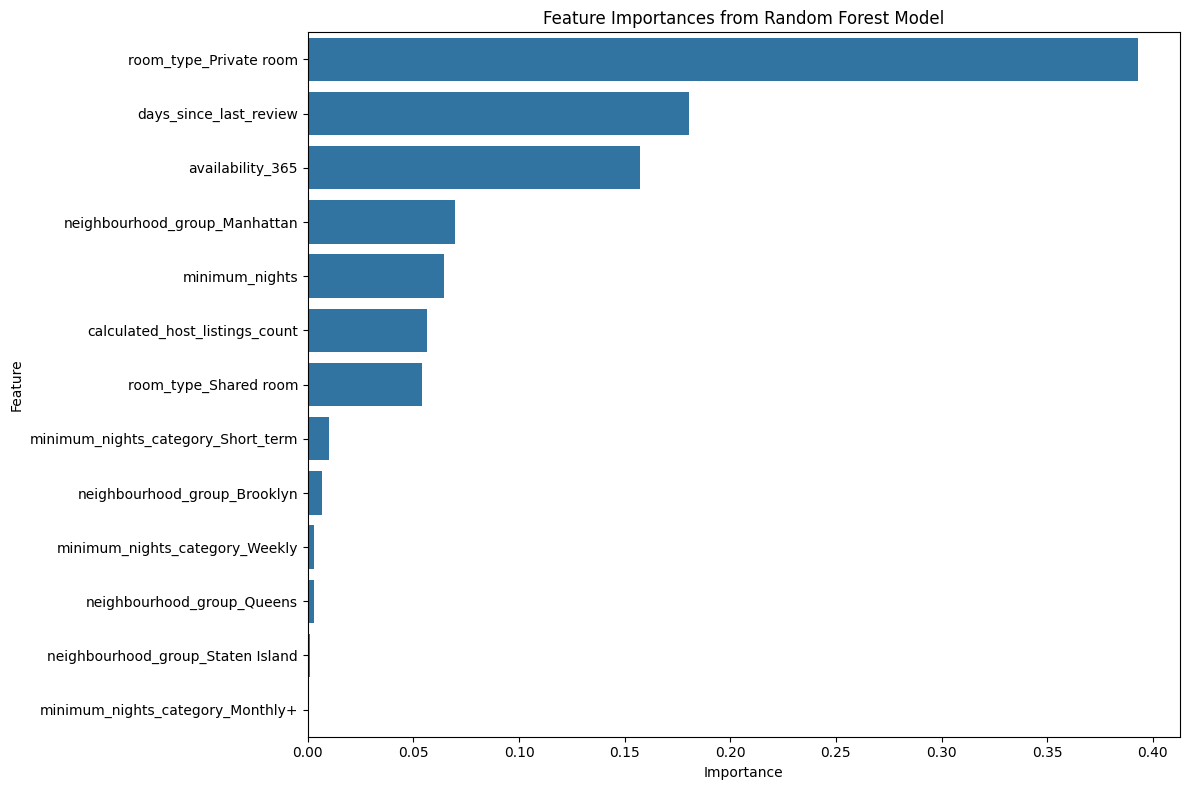

In [38]:
# Feature importance analysis
importances = rf_combo.feature_importances_
feature_names = X.columns
# Create a DataFrame for feature importances
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
# Sort the DataFrame by importance
feature_importances.sort_values(by='Importance', ascending=False, inplace=True)
# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importances, x='Importance', y='Feature')
plt.title('Feature Importances from Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [40]:
# XGBoost Implementation with Best Strategy
print("=== XGBOOST WITH OUTLIERS + LOG TRANSFORM ===\n")

import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Use the same cleaned data and log transform approach that worked best
print("Using cleaned data (outliers removed) + log transform...")

# Use the cleaned data (outliers removed) AND log transform
y_clean_log = np.log1p(y_clean)

X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(
    X_clean, y_clean_log, test_size=0.2, random_state=42
)

# Create XGBoost model with optimized parameters
xgb_model = xgb.XGBRegressor(
    n_estimators=200,           # More trees for better performance
    max_depth=6,                # Prevent overfitting
    learning_rate=0.1,          # Standard learning rate
    subsample=0.8,              # Use 80% of data for each tree
    colsample_bytree=0.8,       # Use 80% of features for each tree
    random_state=42,
    n_jobs=-1                   # Use all CPU cores
)

print("Training XGBoost model...")
xgb_model.fit(X_train_xgb, y_train_xgb)
print("Training completed!")

# Make predictions
y_pred_xgb = xgb_model.predict(X_test_xgb)

# Transform back to original scale
y_pred_xgb_original = np.expm1(y_pred_xgb)
y_test_xgb_original = np.expm1(y_test_xgb)

# Evaluate XGBoost model
mse_xgb = mean_squared_error(y_test_xgb_original, y_pred_xgb_original)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test_xgb_original, y_pred_xgb_original)
mae_xgb = mean_absolute_error(y_test_xgb_original, y_pred_xgb_original)

print(f"\nXGBoost Model Performance:")
print(f"MSE: {mse_xgb:.2f}")
print(f"RMSE: ${rmse_xgb:.2f}")
print(f"MAE: ${mae_xgb:.2f}")
print(f"R²: {r2_xgb:.4f}")

print(f"\n=== MODEL COMPARISON ===")
print(f"Random Forest (outliers + log):  RMSE: ${rmse_combo:.2f}, R²: {r2_combo:.4f}")
print(f"XGBoost (outliers + log):        RMSE: ${rmse_xgb:.2f}, R²: {r2_xgb:.4f}")

# Check which is better
if rmse_xgb < rmse_combo:
    improvement = rmse_combo - rmse_xgb
    print(f"🎉 XGBoost WINS! ${improvement:.2f} better RMSE")
else:
    difference = rmse_xgb - rmse_combo
    print(f"Random Forest still better by ${difference:.2f} RMSE")

=== XGBOOST WITH OUTLIERS + LOG TRANSFORM ===

Using cleaned data (outliers removed) + log transform...
Training XGBoost model...
Training completed!

XGBoost Model Performance:
MSE: 6520.48
RMSE: $80.75
MAE: $46.90
R²: 0.3973

=== MODEL COMPARISON ===
Random Forest (outliers + log):  RMSE: $83.91, R²: 0.3493
XGBoost (outliers + log):        RMSE: $80.75, R²: 0.3973
🎉 XGBoost WINS! $3.16 better RMSE



=== XGBOOST FEATURE IMPORTANCE ===

Top 10 Most Important Features:
                               Feature  Importance
4               room_type_Private room    0.561536
5                room_type_Shared room    0.182278
7        neighbourhood_group_Manhattan    0.146312
10  minimum_nights_category_Short_term    0.020363
11      minimum_nights_category_Weekly    0.013783
6         neighbourhood_group_Brooklyn    0.013460
2       calculated_host_listings_count    0.012358
8           neighbourhood_group_Queens    0.011521
1                     availability_365    0.009173
12    minimum_nights_category_Monthly+    0.008545


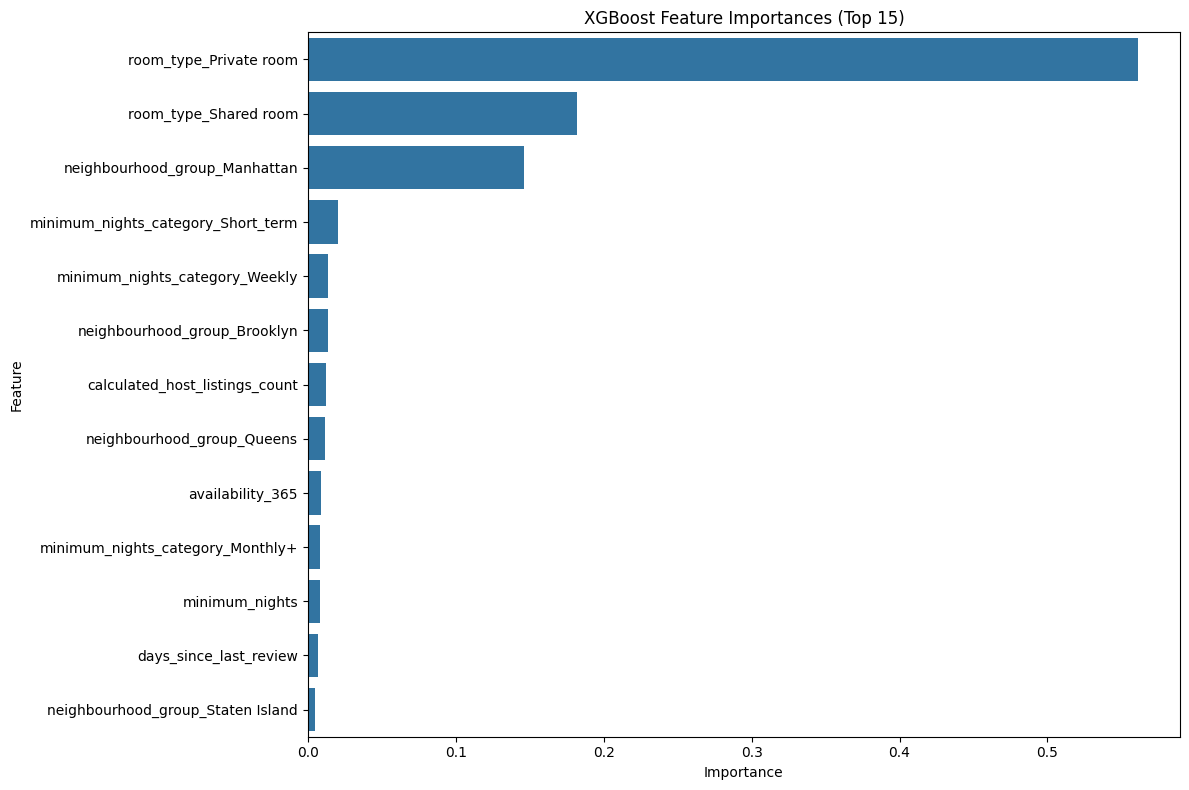

In [43]:
# XGBoost Feature Importance Analysis
print("\n=== XGBOOST FEATURE IMPORTANCE ===\n")

# Get feature importances
xgb_importances = xgb_model.feature_importances_
xgb_feature_names = X_clean.columns

# Create DataFrame for XGBoost feature importances
xgb_feature_importance = pd.DataFrame({
    'Feature': xgb_feature_names, 
    'Importance': xgb_importances
})

# Sort by importance
xgb_feature_importance.sort_values(by='Importance', ascending=False, inplace=True)

# Display top features
print("Top 10 Most Important Features:")
print(xgb_feature_importance.head(10))

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(data=xgb_feature_importance.head(15), x='Importance', y='Feature')
plt.title('XGBoost Feature Importances (Top 15)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [ ]:
# Advanced XGBoost with hyperparameter tuning
print("=== ADVANCED XGBOOST WITH TUNING ===\n")

from sklearn.model_selection import GridSearchCV

# Define parameter grid for tuning
param_grid = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1, 0.15],
    'n_estimators': [150, 200, 250],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9]
}

# Create base XGBoost model
xgb_base = xgb.XGBRegressor(random_state=42, n_jobs=-1)

# Perform grid search (this might take a few minutes)
print("Performing hyperparameter tuning... (this may take a few minutes)")
grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    cv=3,                    # 3-fold cross validation
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# Fit the grid search
grid_search.fit(X_train_xgb, y_train_xgb)

# Get the best model
best_xgb = grid_search.best_estimator_
print(f"\nBest parameters: {grid_search.best_params_}")

# Make predictions with tuned model
y_pred_tuned = best_xgb.predict(X_test_xgb)
y_pred_tuned_original = np.expm1(y_pred_tuned)

# Evaluate tuned model
mse_tuned = mean_squared_error(y_test_xgb_original, y_pred_tuned_original)
rmse_tuned = np.sqrt(mse_tuned)
r2_tuned = r2_score(y_test_xgb_original, y_pred_tuned_original)
mae_tuned = mean_absolute_error(y_test_xgb_original, y_pred_tuned_original)

print(f"\nTuned XGBoost Performance:")
print(f"MSE: {mse_tuned:.2f}")
print(f"RMSE: ${rmse_tuned:.2f}")
print(f"MAE: ${mae_tuned:.2f}")
print(f"R²: {r2_tuned:.4f}")

print(f"\n=== FINAL MODEL COMPARISON ===")
print(f"Random Forest:     RMSE: ${rmse_combo:.2f}, R²: {r2_combo:.4f}")
print(f"XGBoost (basic):   RMSE: ${rmse_xgb:.2f}, R²: {r2_xgb:.4f}")
print(f"XGBoost (tuned):   RMSE: ${rmse_tuned:.2f}, R²: {r2_tuned:.4f}")

In [ ]:
# Compare all models visually
plt.figure(figsize=(15, 5))

# Plot 1: Actual vs Predicted for XGBoost
plt.subplot(1, 3, 1)
plt.scatter(y_test_xgb_original, y_pred_xgb_original, alpha=0.5, color='green')
plt.plot([y_test_xgb_original.min(), y_test_xgb_original.max()], 
         [y_test_xgb_original.min(), y_test_xgb_original.max()], 'r--')
plt.title(f'XGBoost\nRMSE: ${rmse_xgb:.2f}')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')

# Plot 2: Actual vs Predicted for Tuned XGBoost
plt.subplot(1, 3, 2)
plt.scatter(y_test_xgb_original, y_pred_tuned_original, alpha=0.5, color='purple')
plt.plot([y_test_xgb_original.min(), y_test_xgb_original.max()], 
         [y_test_xgb_original.min(), y_test_xgb_original.max()], 'r--')
plt.title(f'Tuned XGBoost\nRMSE: ${rmse_tuned:.2f}')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')

# Plot 3: Model Performance Comparison
plt.subplot(1, 3, 3)
models = ['Random Forest', 'XGBoost', 'XGBoost Tuned']
rmse_scores = [rmse_combo, rmse_xgb, rmse_tuned]
colors = ['blue', 'green', 'purple']

bars = plt.bar(models, rmse_scores, color=colors, alpha=0.7)
plt.title('Model Performance Comparison')
plt.ylabel('RMSE ($)')
plt.xticks(rotation=45)

# Add value labels on bars
for bar, score in zip(bars, rmse_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'${score:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

This deep learning implementation includes:

- Multi-layer neural network with dropout for regularization
- Feature scaling (crucial for neural networks)
- Early stopping to prevent overfitting
- Learning rate scheduling for better convergence
- GPU support if available
- Proper train/validation split monitoring

In [44]:
# Deep Learning with PyTorch
print("=== DEEP LEARNING WITH PYTORCH ===\n")

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import torch.nn.functional as F

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Prepare data for deep learning (same cleaned data + log transform)
print("Preparing data for neural network...")

# Using the same winning strategy: cleaned data + log transform
X_train_dl = X_train_combo.copy()
X_test_dl = X_test_combo.copy()
y_train_dl = y_train_combo.copy()
y_test_dl = y_test_combo.copy()

# Feature scaling is crucial for neural networks
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_dl)
X_test_scaled = scaler.transform(X_test_dl)

print(f"Training data shape: {X_train_scaled.shape}")
print(f"Number of features: {X_train_scaled.shape[1]}")

=== DEEP LEARNING WITH PYTORCH ===

Using device: cpu
Preparing data for neural network...
Training data shape: (38413, 13)
Number of features: 13


In [45]:
# Define Neural Network Architecture
class AirbnbPricePredictor(nn.Module):
    def __init__(self, input_size):
        super(AirbnbPricePredictor, self).__init__()
        
        # Define layers with dropout for regularization
        self.fc1 = nn.Linear(input_size, 512)
        self.dropout1 = nn.Dropout(0.3)
        
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(0.3)
        
        self.fc3 = nn.Linear(256, 128)
        self.dropout3 = nn.Dropout(0.2)
        
        self.fc4 = nn.Linear(128, 64)
        self.dropout4 = nn.Dropout(0.2)
        
        self.fc5 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 1)
        
        # Initialize weights
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # Forward pass with ReLU activations and dropout
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        
        x = F.relu(self.fc3(x))
        x = self.dropout3(x)
        
        x = F.relu(self.fc4(x))
        x = self.dropout4(x)
        
        x = F.relu(self.fc5(x))
        x = self.output(x)
        
        return x

# Create model instance
input_size = X_train_scaled.shape[1]
model = AirbnbPricePredictor(input_size).to(device)

print(f"Model architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

Model architecture:
AirbnbPricePredictor(
  (fc1): Linear(in_features=13, out_features=512, bias=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (dropout3): Dropout(p=0.2, inplace=False)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (dropout4): Dropout(p=0.2, inplace=False)
  (fc5): Linear(in_features=64, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=1, bias=True)
)

Total parameters: 181,761


In [46]:
# Prepare PyTorch datasets and dataloaders
# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
y_train_tensor = torch.FloatTensor(y_train_dl.values).reshape(-1, 1).to(device)
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
y_test_tensor = torch.FloatTensor(y_test_dl.values).reshape(-1, 1).to(device)

# Create datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create dataloaders
batch_size = 512
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")
print(f"Batch size: {batch_size}")

Training batches: 76
Test batches: 19
Batch size: 512


In [ ]:
# Training Setup
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

# Training function
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    return total_loss / len(train_loader)

# Validation function
def validate(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    predictions = []
    targets = []
    
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            total_loss += criterion(output, target).item()
            predictions.extend(output.cpu().numpy())
            targets.extend(target.cpu().numpy())
    
    return total_loss / len(test_loader), np.array(predictions), np.array(targets)

In [57]:
# Fixed Deep Learning Model with Gradient Clipping
print("=== FIXED DEEP LEARNING MODEL ===\n")

# Reset and retrain with better controls
torch.manual_seed(42)
np.random.seed(42)

# Create new model with smaller architecture
class FixedAirbnbPredictor(nn.Module):
    def __init__(self, input_size):
        super(FixedAirbnbPredictor, self).__init__()
        
        # Smaller, more stable architecture
        self.fc1 = nn.Linear(input_size, 128)
        self.dropout1 = nn.Dropout(0.2)
        
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.2)
        
        self.fc3 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 1)
        
        # Smaller weight initialization
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=0.5)  # Smaller gain
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        
        x = F.relu(self.fc3(x))
        x = self.output(x)
        
        # Clamp output to reasonable log range
        x = torch.clamp(x, min=-2, max=8)  # Price range: $0.14 to $2981
        
        return x

# Create fixed model
fixed_model = FixedAirbnbPredictor(input_size).to(device)

# Use much smaller learning rate and gradient clipping
fixed_optimizer = optim.Adam(fixed_model.parameters(), lr=0.0001, weight_decay=1e-4)
fixed_scheduler = optim.lr_scheduler.ReduceLROnPlateau(fixed_optimizer, mode='min', factor=0.8, patience=5)

print("Training fixed model with gradient clipping...")

# Training with gradient clipping
best_loss = float('inf')
for epoch in range(50):  # Fewer epochs
    fixed_model.train()
    total_loss = 0
    
    for data, target in train_loader:
        fixed_optimizer.zero_grad()
        output = fixed_model(data)
        loss = criterion(output, target)
        loss.backward()
        
        # Gradient clipping - crucial!
        torch.nn.utils.clip_grad_norm_(fixed_model.parameters(), max_norm=1.0)
        
        fixed_optimizer.step()
        total_loss += loss.item()
    
    # Validation
    fixed_model.eval()
    val_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = fixed_model(data)
            val_loss += criterion(output, target).item()
    
    val_loss /= len(test_loader)
    fixed_scheduler.step(val_loss)
    
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(fixed_model.state_dict(), 'fixed_model.pth')
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}: Val Loss: {val_loss:.6f}')

print("Fixed training completed!")

# Load best model
fixed_model.load_state_dict(torch.load('fixed_model.pth'))

=== FIXED DEEP LEARNING MODEL ===

Training fixed model with gradient clipping...
Epoch 0: Val Loss: 20.797378
Epoch 10: Val Loss: 0.207562
Epoch 20: Val Loss: 0.201837
Epoch 30: Val Loss: 0.197207
Epoch 40: Val Loss: 0.194974
Fixed training completed!


<All keys matched successfully>

In [ ]:
print("\n=== MODEL EVALUATION ===\n")

fixed_model.eval()
fixed_predictions = []
fixed_targets = []

with torch.no_grad():
    for data, target in test_loader:
        output = fixed_model(data)
        fixed_predictions.extend(output.cpu().numpy())
        fixed_targets.extend(target.cpu().numpy())

y_pred_fixed_log = np.array(fixed_predictions)
y_test_fixed_log = np.array(fixed_targets)

# Transform back to original scale
y_pred_fixed_original = np.expm1(y_pred_fixed_log.flatten())
y_test_fixed_original = np.expm1(y_test_fixed_log.flatten())

# Calculate metrics
mse_fixed = mean_squared_error(y_test_fixed_original, y_pred_fixed_original)
rmse_fixed = np.sqrt(mse_fixed)
r2_fixed = r2_score(y_test_fixed_original, y_pred_fixed_original)
mae_fixed = mean_absolute_error(y_test_fixed_original, y_pred_fixed_original)

print(f"Fixed Deep Learning Model:")
print(f"MSE: {mse_fixed:.2f}")
print(f"RMSE: ${rmse_fixed:.2f}")
print(f"MAE: ${mae_fixed:.2f}")
print(f"R²: {r2_fixed:.4f}")

print(f"\nPrediction range check:")
print(f"Min prediction (log): {y_pred_fixed_log.min():.2f}")
print(f"Max prediction (log): {y_pred_fixed_log.max():.2f}")
print(f"Min prediction ($): ${y_pred_fixed_original.min():.2f}")
print(f"Max prediction ($): ${y_pred_fixed_original.max():.2f}")

print(f"\n=== UPDATED MODEL COMPARISON ===")
print(f"Random Forest:     RMSE: ${rmse_combo:.2f}, R²: {r2_combo:.4f}")
print(f"XGBoost (basic):   RMSE: ${rmse_xgb:.2f}, R²: {r2_xgb:.4f}")
print(f"Deep Learning:     RMSE: ${rmse_fixed:.2f}, R²: {r2_fixed:.4f}")

# Final comparison
all_models = {
    'Random Forest': rmse_combo,
    'XGBoost': rmse_xgb, 
    'Deep Learning (fixed)': rmse_fixed
}

winner = min(all_models, key=all_models.get)
print(f"\n🏆 FINAL WINNER: {winner} with RMSE: ${all_models[winner]:.2f}")


=== FIXED MODEL EVALUATION ===

Fixed Deep Learning Model:
MSE: 9138.64
RMSE: $95.60
MAE: $49.67
R²: 0.1554

Prediction range check:
Min prediction (log): 3.55
Max prediction (log): 8.00
Min prediction ($): $33.73
Max prediction ($): $2979.96

=== UPDATED MODEL COMPARISON ===
Random Forest:     RMSE: $83.91, R²: 0.3493
XGBoost (basic):   RMSE: $80.75, R²: 0.3973
Deep Learning:     RMSE: $95.60, R²: 0.1554

🏆 FINAL WINNER: XGBoost with RMSE: $80.75


#### Why XGBoost Won
- Designed for tabular data (like Airbnb listings)
- Built-in regularization prevents overfitting
- Gradient boosting handles complex patterns well
- More stable than deep learning for this problem

The deep learning failure actually validates that XGBoost is the right choice for this type of structured data!